Training NN for recognition of satellite images <br>
EuroSAT dataset <br>

Working plan:
- Create transform to be used in dataloader
- Load EuroSAT dataset
- Split the dataset into train and test samples
- Create train and test dataloaders 
- Create convolution NN model with dropouts and batch normalizers
- Train CNN on the basis of the test dataset
- Check metrics on the test dataset
- Make conclusions

0. Importing necessary modules and the mnist dataset which is a part of tensorflow package

In [34]:
%reset -f 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [35]:
dtype = torch.float # speeding up on the GPU

1. CUDA enable (pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118)

In [36]:
print(f'CUDA is available: {torch.cuda.is_available()}')  # True
if torch.cuda.is_available():
    print(f'Device count: {torch.cuda.device_count()}')   #1
    print(f'Current device #: {torch.cuda.current_device()}')  # 0
    print(f'GPU name: {torch.cuda.get_device_name(0)}') 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

CUDA is available: False
Device: cpu


2. Creating augmentation transform for loading Satellite data

In [37]:
input_size = (64, 64)  # picture size 
# Data augmentation

transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-90,90)),  # rotate the image
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear = 10),  # affine transformations: translation, shear
    transforms.RandomZoomOut(fill=0, side_range=(1.1, 1.1)), # zooming out, helps to decrease features in the image
    transforms.Resize(size = (64,64)), # necessary since zoom out makes image larger, counting in pixels
    transforms.RandomResizedCrop(size=input_size, ratio=(1.5, 1.5)),  # resize and crop - helps to increase picture
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # randomly change the brightness and contrast of images    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.34437596, 0.38029084, 0.40777029], std=[0.20266077, 0.13689659, 0.11555012]),  # Normalization based on the previously extracted average values    
])

3. Loading the Satellite dataset, automatically assigning labels, and simultaneoulsy apply the augmentation

In [38]:
# Load Satellite dataset with the specified input size
data_dir = '2750'
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

4. Creating data loaders with predefined batch size

In [39]:
batch_size = 32

# Setting the sizes for the train and test sets (80% by 20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Random data division
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
# Classes for EurSAT images
classes = full_dataset.classes
print(f"Classes: {classes}, total {len(classes)}")

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], total 10


In [41]:
# Showing some pictures after augmentation (in gray colormap):
for someimages, somelabels in test_loader:
    break # we only need one batch

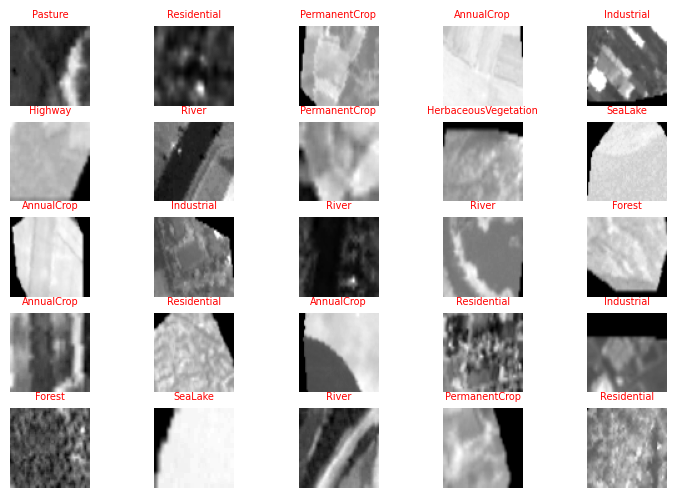

In [42]:
# Define a function to display images
def show_images(imgs, lbls):
     fig, axes = plt.subplots(5, 5, figsize=(9, 6))
     for i, ax in enumerate(axes.flatten()):
         image_reshaped = np.transpose(imgs[i], (1, 2, 0))
         # scale channels to [0;1] to be able to show the image
         for j in range(3):
            image_reshaped[:,:,j] = (image_reshaped[:,:,j]  - torch.min(image_reshaped[:,:,j])) / (torch.max(image_reshaped[:,:,j]) - torch.min(image_reshaped[:,:,j]))
         img = 1/3 *(image_reshaped[:,:,0] + image_reshaped[:,:,1] + image_reshaped[:,:,2]) 
         ax.imshow(img, cmap = 'gray')
         current_label = classes[somelabels[i]]
         # print(f'i={i}, current label: {current_label}')
         ax.set_title(current_label, fontsize = 7, color = 'red')
         ax.axis('off')
     plt.show()

# Call the function to display the images
show_images(someimages, somelabels)

5. Building the neural network model with augmentation using pytorch

In [43]:
# 5. Create the model class + initialize the model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.5)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.5)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # 64 channels * 16 x 16
        self.fc2 = nn.Linear(128, len(classes))  # Number of classes

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = x.view(-1, 64 * 16 * 16)  # Transform to 1D vector
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

6. Initializing the model

In [44]:
# 6. Initialize the model, loss function, and optimizer

model = CNNModel().to(device) # Creating the model and moving to the working device
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

7. Training the model

In [65]:
epochs = 50

# 7. Train the model

for epoch in range(epochs):
    print(f'Epoch [{epoch+1}/{epochs}]')
    correct = 0
    total = 0
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # Forward pass:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Control current learning state
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
            
    print(f'Train Accuracy: {100 * correct / total:.2f}%, Average Loss: {loss.item():.4f}')

Epoch [1/50]
Train Accuracy: 80.26%, Average Loss: 1.0416
Epoch [2/50]
Train Accuracy: 80.10%, Average Loss: 0.6266
Epoch [3/50]
Train Accuracy: 79.92%, Average Loss: 0.6465
Epoch [4/50]
Train Accuracy: 80.17%, Average Loss: 0.4977
Epoch [5/50]
Train Accuracy: 80.21%, Average Loss: 0.3561
Epoch [6/50]
Train Accuracy: 80.62%, Average Loss: 0.4926
Epoch [7/50]
Train Accuracy: 80.30%, Average Loss: 0.6484
Epoch [8/50]
Train Accuracy: 80.25%, Average Loss: 0.6209
Epoch [9/50]
Train Accuracy: 80.21%, Average Loss: 0.5872
Epoch [10/50]
Train Accuracy: 80.77%, Average Loss: 0.5734
Epoch [11/50]
Train Accuracy: 80.24%, Average Loss: 0.3115
Epoch [12/50]
Train Accuracy: 80.07%, Average Loss: 0.7383
Epoch [13/50]
Train Accuracy: 80.68%, Average Loss: 0.7987
Epoch [14/50]
Train Accuracy: 80.28%, Average Loss: 0.5189
Epoch [15/50]
Train Accuracy: 80.40%, Average Loss: 0.6197
Epoch [16/50]
Train Accuracy: 80.61%, Average Loss: 0.3429
Epoch [17/50]
Train Accuracy: 80.60%, Average Loss: 0.3175
Epoch 

8. Evaluate the model using the Satellite _train_ dataset

In [66]:
# Evaluation on the train set

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy (train): {100 * correct / total:.2f}%')

Accuracy (train): 80.87%


9. Evaluating the model using the Satellite test dataset

In [67]:
# Evaluation on the test set

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy (test): {100 * correct / total:.2f}%')

Accuracy (test): 79.89%


We have trained a convolutional NN for classification of EuroSAT images.

Augmentation is used for the images loaded. <br>
Dropout and batch normalization is used for improving the model convergence. <br> 

The results for minimum augmentation are the following: <br> 
(transform = transforms.Compose([ <br> 
    transforms.RandomRotation(degrees=(-1,1)),  # rotate the image <br> 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear = 0),  # affine transformations: translation, zero shear <br> 
    transforms.RandomZoomOut(fill=0, side_range=(1.0, 1.0)), # zooming out, helps to decrease features in the image <br> 
    transforms.Resize(size = (64,64)), # necessary since zoom out makes image larger, counting in pixels <br> 
    transforms.RandomResizedCrop(size=input_size, ratio=(1, 1)),  # resize and crop - helps to increase picture <br> 
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # randomly change the brightness and contrast of images  <br>    
    transforms.ToTensor(),  <br> 
    transforms.Normalize(mean=[0.34437596, 0.38029084, 0.40777029], std=[0.20266077, 0.13689659, 0.11555012]),  # Normalization based on the previously extracted average values     <br> 
])) <br> 

5 epochs, batch size 32:  65.72% recognition on the test sample <br>
20 epochs, batch size 32: 73.37% recognition on the test sample <br>
50 epochs, batch size 32: 79.20% recognition on the test sample <br>
100 epochs, batch size 32: 83.30% recognition on the test sample <br>
150 epochs, batch size 32: 82.89% recognition on the test sample <br>

With more agressive augmentation we have: <br> 
(transform = transforms.Compose([ <br> 
    transforms.RandomRotation(degrees=(-90,90)),  # rotate the image <br> 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear = 10),  # affine transformations: translation, shear <br> 
    transforms.RandomZoomOut(fill=0, side_range=(1.1, 1.1)), # zooming out, helps to decrease features in the image <br> 
    transforms.Resize(size = (64,64)), # necessary since zoom out makes image larger, counting in pixels <br> 
    transforms.RandomResizedCrop(size=input_size, ratio=(1.5, 1.5)),  # resize and crop - helps to increase picture <br> 
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # randomly change the brightness and contrast of images     <br> 
    transforms.ToTensor(), <br> 
    transforms.Normalize(mean=[0.34437596, 0.38029084, 0.40777029], std=[0.20266077, 0.13689659, 0.11555012]),  # Normalization based on the previously extracted average values<br>
]))  <br> 

5 epochs, batch size 32:  63.59% recognition on the test sample <br>
20 epochs, batch size 32: 72.72% recognition on the test sample <br>
50 epochs, batch size 32: 75.70% recognition on the test sample <br>
100 epochs, batch size 32: 76.07% recognition on the test sample <br>
150 epochs, batch size 32: 77.63% recognition on the test sample <br>
200 epochs, batch size 32: 79.37% recognition on the test sample <br>
250 epochs, batch size 32: 79.89% recognition on the test sample <br>

We achieved the best result for classification of EurSAT images as large as 83.3%. <br>
Note that according to the following: <br>
https://rmnng.medium.com/satellite-images-classification-using-the-eurosat-dataset-13f7fd1edc42 <br>
the result achievable for convolution neural network with three convolution layers is about 85%. <br>
(Acc. to other Internet sources, while using the most advanced and sophisticated NN architectures the accuracy about 98% can be achieved).